# This notebook is for Kaggle competition https://www.kaggle.com/c/realestatepriceprediction.
## In this competition the task is to predict the price of flats in test.csv. Two datasets are given: train.csv (contains all features and prices of flats) and test.csv (only features).
### Data files can be downloaded from competition's page.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score as r2

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
rnd_state = 42

# Load train data

In [3]:
train_df = pd.read_csv('train.csv', sep=',')

train_df.head(10)  

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [4]:
train_df.shape

(10000, 20)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [6]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Looks like Healthcare_1 is unusefull feature.

In [7]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


The dataset contains many issues.

# Load test data

In [8]:
test_df = pd.read_csv('test.csv', sep=',')

# Features engineering

### Data preparing function

In [9]:
def data_preparing(X, medians, y=None):
    
    label_to_num_dict = {'A': 0, 'B': 1}  # dict for transform categorical data
    
    X.drop('Id', axis=1, inplace=True)  # remove Id column
    X.drop('Healthcare_1', axis=1, inplace=True)  # remove Healthcare_1 column because it contains too many nulls
    
    X.drop('Ecology_2', axis=1, inplace=True)  # looks like without ecology_2 results are better (got emperical)

    # I think 0 rooms can be in studio-flat
    X.loc[X['Rooms'] > 5, 'Rooms'] = medians['Rooms']  # more than 5 rooms looks like ejection
    
    X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3  # KitchenSquare (looks like ejection)
    # when KS > S set KS as S - LS if LS < S
    X.loc[(X['KitchenSquare'] > X['Square']) & (X['Square'] > X['LifeSquare']), 'KitchenSquare'] = X['Square'] - X['LifeSquare']
    # when KS > S set KS as S if LS > S or LS is None
    X.loc[X['KitchenSquare'] > X['Square'], 'KitchenSquare'] = X['Square']
    
    X.loc[X['HouseFloor'] < 1, 'HouseFloor'] = medians['HouseFloor']  # floor can't be less than 1  
    # floor can't be greater than HouseFloor
    X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
    # floor can't be less than 1
    X.loc[X['Floor'] < 1, 'Floor'] = 1
    
    # HouseYear can't be greater then the current year
    X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
    
    X.loc[X['LifeSquare'].isnull(), 'LifeSquare'] = medians['LifeSquare']  # set median if None
    # if greater than S-KS set as S-KS
    X.loc[X['LifeSquare'] > (X['Square'] - X['KitchenSquare']), 'LifeSquare'] = X['Square'] - X['KitchenSquare']
    
    X['Ecology_3'] = X['Ecology_3'].map(label_to_num_dict)  # transform categorical
    X['Shops_2'] = X['Shops_2'].map(label_to_num_dict)
    
    # Looks like a usefull feature
    X['KitchenSquare_relative'] = X['KitchenSquare']/X['Square']

    mean_price_by_district = None
    if y is not None:
        X_local = X.copy()
        X_local['Price'] = y
        
        # mean price per square meter by districts
        mean_price_by_district = X_local.groupby(['DistrictId'], as_index=False).agg({'Price':'sum', 'Square':'sum'})
        mean_price_by_district['MedMeterPriceByDistr'] = mean_price_by_district['Price'] / mean_price_by_district['Square']
        mean_price_by_district.drop('Price', axis=1, inplace=True)
        mean_price_by_district.drop('Square', axis=1, inplace=True)

    return mean_price_by_district

### Shuffle data

In [10]:
train_df = train_df.sample(frac=1, random_state=rnd_state).reset_index(drop=True)

### Split data into train and target and prepare train

In [12]:
X = train_df[train_df.columns[:-1]].copy()
y = train_df['Price'].copy()
train_medians = X.median()

# add new columns with mean meter price by district
mean_price_distr = data_preparing(X, train_medians, y)
X = pd.merge(X, mean_price_distr, on='DistrictId', how='left')
# remove DistrictId
X.drop('DistrictId', axis=1, inplace=True)
X.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,KitchenSquare_relative,MedMeterPriceByDistr
0,2.0,48.812195,34.679779,5.0,5.0,5.0,1963,0.034331,1,25,5487,3,0,4,1,0.102433,4062.599773
1,3.0,81.103039,49.310278,8.0,4.0,4.0,1960,0.298205,1,16,4048,3,1,3,1,0.098640,4291.717138
2,3.0,82.882978,3.977650,3.0,8.0,17.0,1977,0.243205,1,5,1564,0,0,0,1,0.036196,2866.703578
3,1.0,33.863324,29.993297,3.0,4.0,4.0,1977,0.034656,1,0,168,0,0,0,1,0.088591,2239.484158
4,1.0,43.095135,32.781260,3.0,10.0,17.0,1977,0.371149,1,34,7065,1,2,5,1,0.069613,3022.772701
5,3.0,84.569998,60.613297,12.0,18.0,24.0,2017,0.049637,1,34,7759,0,1,3,1,0.141894,4766.966334
6,2.0,54.663924,29.266790,9.0,13.0,17.0,1999,0.000991,1,33,6783,3,1,9,1,0.164642,5262.546993
7,1.0,33.521641,30.155171,3.0,16.0,16.0,2015,0.282798,1,33,8667,2,0,6,1,0.089494,4176.484709
8,1.0,40.696294,37.696294,3.0,4.0,17.0,2014,0.243205,1,5,1564,0,0,0,1,0.073717,2866.703578
9,2.0,44.369058,31.064926,5.0,1.0,5.0,1965,0.188784,1,31,6137,4,0,1,1,0.112691,4319.792576


In [14]:
X_test = test_df.copy()

# add new columns with mean meter price by district
data_preparing(X_test, train_medians)
X_test = pd.merge(X_test, mean_price_distr, on='DistrictId', how='left')
# remove DistrictId
X_test.drop('DistrictId', axis=1, inplace=True)

# set median MedMeterPriceByDistr where is null
X_test.loc[X_test['MedMeterPriceByDistr'].isnull(), 'MedMeterPriceByDistr'] = X_test['MedMeterPriceByDistr'].median()

### Cross validation function

In [15]:
def cross_validation(X, y, model):

    test_len = int(X.shape[0] * 0.2)

    r2_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

    for i in range(5):

        start = i * test_len

        X_test = X.loc[start: (start + test_len - 1), :]
        y_test = y.loc[start: (start + test_len - 1)]

        X_Train_1 = X.loc[:(start - 1), :]
        X_Train_2 = X.loc[(start + test_len):, :]
        X_Train = pd.concat([X_Train_1, X_Train_2], axis=0)
        y_Train_1 = y.loc[:(start - 1)]
        y_Train_2 = y.loc[(start + test_len):]
        y_Train = pd.concat([y_Train_1, y_Train_2], axis=0)

        model.fit(X_Train, y_Train)

        y_pred = model.predict(X_test)

        r2_arr[i] = r2(y_test, y_pred)

    return r2_arr.mean()

## Plot data with tSNE

In [16]:
# set scaler
scaler = MinMaxScaler()

X_train = X.copy()
X_train['Price'] = y

In [17]:
# scaling
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

X_train_scaled.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,KitchenSquare_relative,MedMeterPriceByDistr,Price
0,0.4,0.074501,0.054954,0.035532,0.097561,0.034483,0.481818,0.065786,1.0,0.337838,0.281205,0.021277,0.000000,0.173913,1.0,0.097958,0.318532,0.213141
1,0.6,0.124961,0.078138,0.060052,0.073171,0.025862,0.454545,0.571419,1.0,0.216216,0.205128,0.021277,0.166667,0.130435,1.0,0.094146,0.348974,0.350628
2,0.6,0.127743,0.006303,0.019185,0.170732,0.137931,0.609091,0.466028,1.0,0.067568,0.073804,0.000000,0.000000,0.000000,1.0,0.031390,0.159636,0.280059
3,0.2,0.051141,0.047528,0.019185,0.073171,0.025862,0.609091,0.066408,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.084047,0.076298,0.013428
4,0.2,0.065567,0.051946,0.019185,0.219512,0.137931,0.609091,0.711195,1.0,0.459459,0.364631,0.007092,0.333333,0.217391,1.0,0.064975,0.180372,0.095654
5,0.6,0.130379,0.096049,0.092746,0.414634,0.198276,0.972727,0.095115,1.0,0.459459,0.401322,0.000000,0.166667,0.130435,1.0,0.137616,0.412120,0.522404
6,0.4,0.083645,0.046377,0.068226,0.292683,0.137931,0.809091,0.001900,1.0,0.445946,0.349722,0.021277,0.166667,0.391304,1.0,0.160477,0.477967,0.554421
7,0.2,0.050607,0.047785,0.019185,0.365854,0.129310,0.954545,0.541896,1.0,0.445946,0.449326,0.014184,0.000000,0.260870,1.0,0.084955,0.333664,0.562203
8,0.2,0.061819,0.059734,0.019185,0.073171,0.137931,0.945455,0.466028,1.0,0.067568,0.073804,0.000000,0.000000,0.000000,1.0,0.069099,0.159636,0.128728
9,0.4,0.067558,0.049226,0.035532,0.000000,0.034483,0.500000,0.361747,1.0,0.418919,0.315570,0.028369,0.000000,0.043478,1.0,0.108267,0.352705,0.217506


In [18]:
tSNE = TSNE(n_components=2, learning_rate=250, random_state=rnd_state)

In [19]:
X_train_tsne = tSNE.fit_transform(X_train_scaled)

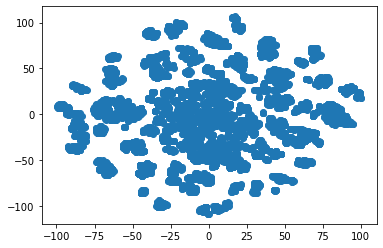

In [20]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])

plt.show()

Looks like the data can be clustered well. Lets use it!

## Clusterization

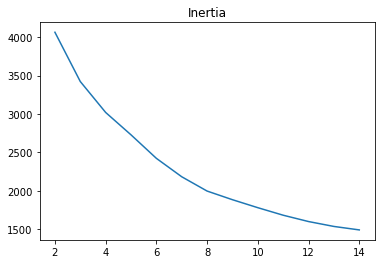

Wall time: 4.65 s


In [21]:
%%time
inertias = []
k = 15

for i in range(2, k):
    temp_model = KMeans(n_clusters=i, random_state=rnd_state)
    temp_model.fit(X_train_scaled)
    
    temp_inertia = temp_model.inertia_
    
    inertias.append(temp_inertia)

plt.plot(range(2, k), inertias)

plt.title('Inertia')

plt.show()

Looks like 9 is good choise for cluster splitting

In [22]:
num_of_clusters = 9
model = KMeans(n_clusters=num_of_clusters, random_state=rnd_state)

In [23]:
X_train_labels = model.fit_predict(X_train_scaled)

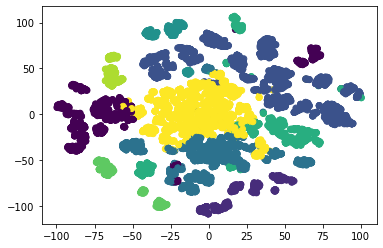

In [24]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=X_train_labels)

plt.show()

### Add clusters labels

In [25]:
X_train_cl = X_train.copy()
X_train_cl['Cluster'] = X_train_labels

X_train_cl.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,KitchenSquare_relative,MedMeterPriceByDistr,Price,Cluster
0,2.0,48.812195,34.679779,5.0,5.0,5.0,1963,0.034331,1,25,5487,3,0,4,1,0.102433,4062.599773,181530.459031,8
1,3.0,81.103039,49.310278,8.0,4.0,4.0,1960,0.298205,1,16,4048,3,1,3,1,0.098640,4291.717138,260456.004692,5
2,3.0,82.882978,3.977650,3.0,8.0,17.0,1977,0.243205,1,5,1564,0,0,0,1,0.036196,2866.703578,219945.304640,2
3,1.0,33.863324,29.993297,3.0,4.0,4.0,1977,0.034656,1,0,168,0,0,0,1,0.088591,2239.484158,66883.280318,2
4,1.0,43.095135,32.781260,3.0,10.0,17.0,1977,0.371149,1,34,7065,1,2,5,1,0.069613,3022.772701,114086.065201,5
5,3.0,84.569998,60.613297,12.0,18.0,24.0,2017,0.049637,1,34,7759,0,1,3,1,0.141894,4766.966334,359065.287230,8
6,2.0,54.663924,29.266790,9.0,13.0,17.0,1999,0.000991,1,33,6783,3,1,9,1,0.164642,5262.546993,377445.078933,8
7,1.0,33.521641,30.155171,3.0,16.0,16.0,2015,0.282798,1,33,8667,2,0,6,1,0.089494,4176.484709,381912.162109,5
8,1.0,40.696294,37.696294,3.0,4.0,17.0,2014,0.243205,1,5,1564,0,0,0,1,0.073717,2866.703578,133072.279471,2
9,2.0,44.369058,31.064926,5.0,1.0,5.0,1965,0.188784,1,31,6137,4,0,1,1,0.112691,4319.792576,184036.005146,8


### Classification for test data

In [26]:
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [27]:
k_values = 5

clf = KNeighborsClassifier(n_neighbors=k_values)
    
X_ts = X_train_scaled.drop('Price', axis=1)
clf.fit(X_ts, X_train_labels)
    
Cluster_pred = clf.predict(X_test_scaled)

X_test_classes = X_test.copy()
X_test_classes['Cluster'] =  Cluster_pred

# Prediction with cluster information

In [28]:
y = X_train_cl['Price'].copy()
X = X_train_cl.copy()
X.drop('Price', axis=1, inplace=True)

X.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,KitchenSquare_relative,MedMeterPriceByDistr,Cluster
0,2.0,48.812195,34.679779,5.0,5.0,5.0,1963,0.034331,1,25,5487,3,0,4,1,0.102433,4062.599773,8
1,3.0,81.103039,49.310278,8.0,4.0,4.0,1960,0.298205,1,16,4048,3,1,3,1,0.098640,4291.717138,5
2,3.0,82.882978,3.977650,3.0,8.0,17.0,1977,0.243205,1,5,1564,0,0,0,1,0.036196,2866.703578,2
3,1.0,33.863324,29.993297,3.0,4.0,4.0,1977,0.034656,1,0,168,0,0,0,1,0.088591,2239.484158,2
4,1.0,43.095135,32.781260,3.0,10.0,17.0,1977,0.371149,1,34,7065,1,2,5,1,0.069613,3022.772701,5
5,3.0,84.569998,60.613297,12.0,18.0,24.0,2017,0.049637,1,34,7759,0,1,3,1,0.141894,4766.966334,8
6,2.0,54.663924,29.266790,9.0,13.0,17.0,1999,0.000991,1,33,6783,3,1,9,1,0.164642,5262.546993,8
7,1.0,33.521641,30.155171,3.0,16.0,16.0,2015,0.282798,1,33,8667,2,0,6,1,0.089494,4176.484709,5
8,1.0,40.696294,37.696294,3.0,4.0,17.0,2014,0.243205,1,5,1564,0,0,0,1,0.073717,2866.703578,2
9,2.0,44.369058,31.064926,5.0,1.0,5.0,1965,0.188784,1,31,6137,4,0,1,1,0.112691,4319.792576,8


# Cross-Validation

In [35]:
model = CatBoostRegressor(silent=True, eval_metric='R2', max_depth=8, cat_features=['Ecology_3', 'Shops_2', 'Cluster'], random_state=rnd_state)
r2_mean = cross_validation(X, y, model)
r2_mean

0.7694550061256017

# Fit the model

In [36]:
model.fit(X, y)

### Predict

In [37]:
y_pred_cl = model.predict(X_test_classes)

### Save predictions

In [38]:
ss_df = pd.DataFrame({
    "Id": test_df["Id"],
    "Price": y_pred_cl,
})

ss_df.head(10)

,Id,Price
0,725,150862.662504
1,15856,218014.726710
2,5480,315727.050907
3,15664,345894.745875
4,14275,150853.995132
5,7633,223800.372134
6,13329,164028.049342
7,5502,224346.447876
8,4220,297924.833921
9,11538,196204.090582


In [39]:
ss_df.to_csv("sample_submission_ermnik_with_clusters.csv", sep=",", index=False)

### Features importance (with clusters info)

In [40]:
importances = model.feature_importances_

importance = pd.Series(importances, index=X_test_classes.columns)
importance.sort_values(ascending=False, inplace=True)
importance

Square                    28.285643
MedMeterPriceByDistr      23.301444
HouseYear                  7.167023
KitchenSquare_relative     4.301957
LifeSquare                 3.998634
KitchenSquare              3.866589
HouseFloor                 3.856115
Ecology_1                  3.752466
Floor                      3.430719
Social_2                   3.413227
Social_3                   3.230436
Rooms                      2.767584
Social_1                   2.721287
Cluster                    2.524809
Shops_1                    1.725032
Helthcare_2                1.453899
Shops_2                    0.103682
Ecology_3                  0.099452
dtype: float64